## 第二週作業 02/25: 打造自己的DNN手寫辨識模型
📌 臺灣師範大學 | 613K0019C | AI所碩一 | 劉思廷

## Gradio 套件介紹

Gradio 是一個 Python 套件，專為快速建立機器學習和深度學習應用的 Web 介面設計。它允許開發者：
- 透過簡單的 API 建立可交互的 UI
- 快速分享模型給他人測試（提供 **public link**）
- 支援 **本地運行** 或 **雲端部署**


In [1]:
""" 安裝與匯入 Gradio 套件 """
!pip install gradio
import gradio as gr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.1/322.1 kB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 97.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 5.6 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
to

## TensorFlow 套件簡介:
1. `import tensorflow as tf`: <br>
  - TensorFlow 是 Google 開發的機器學習框架
  - 主要用於深度學習模型的構建、訓練和部署
  - 支援 GPU/TPU 加速計算
  - 適用於各種 AI 應用，如影像識別、自然語言處理（NLP）等
2. `from tensorflow import keras`: <br>
  - Keras 是 TensorFlow 提供的高階 API，用於簡化神經網路的開發
  - 可供快速構建模型
  - 內建優化器與損失函數
  - 簡化數據處理與訓練流程
3. `from tensorflow.keras.datasets import mnist`: <br>
  - MNIST 是一個經典的手寫數字影像數據集
  - 包含 60,000 張訓練圖片和 10,000 張測試圖片
4. `from tesnorflow.keras.utils import to_categorical`: <br>
  - utils (utilities) 通常是提供與主要功能相關的工具
  - `to_categorical()`用於將標籤轉換為 One-hot 編碼格式，適用分類問題
5. `from tensorflow.keras.models import Model`: <br>
  - 用於建立函數式 API（Functional API）的神經網路
6. `from tensorflow.keras.layers import Dense, Flatten, Concatenate`: <br>
  - `Dense`: 全連接層（Fully Connected Layer），每個神經元與上一層的所有神經元相連
  - `Flatten`: 將多維輸入展平為一維，例如將 28x28 的影像轉換為 784 維的向量
  - `Concatenate`: 可將張量合併在一起
7. `from tensorflow.keras.optimizers import Adam`: <br>
  - `Adam`（Adaptive Moment Estimation）是一種常用的梯度下降優化器


In [2]:
""" 啟用內嵌繪圖模式，讓 matplotlib 圖表直接顯示在輸出區塊 """
%matplotlib inline

""" 固定四行引用套件 """
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image

""" 神經網路相關套件匯入 """
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Concatenate
from tensorflow.keras.optimizers import Adam

""" 由 Keras 讀入 MNIST 資料集 """
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print(f'訓練資料有{len(x_train)}筆, 測試資料有{len(x_test)}筆') # 確認訓練、測試資料是否分別為60000、10000筆

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
訓練資料有60000筆, 測試資料有10000筆


## 模型輸出格式:

🔖 在進行分類任務時，直覺上可能會希望模型直接輸出一個數值標籤。例如:
- 在手寫數字辨識任務中，當模型看到一張數字 "5" 的手寫圖像時，是否可以讓模型學習直接輸出 "5" 呢？

❓ 為什麼這樣的做法不合適? <br>
- 大部分的分類問題中，**類別之間沒有數值順序或距離概念**
- 如果使用單一數值作為標籤，模型可能會誤解這些數值之間的關係。例如：
  - "5" 和 "6" 的距離與 "5" 和 "9" 的距離在數值上是不同的，但在分類問題中，這種「距離」並沒有意義
  - 若模型學習到類別之間的數值關係可能會誤認為 "5" 和 "6" 比 "5" 和 "9" 更相似，進而影響分類的準確性

✔️ **解決方案：使用 One-Hot 編碼** (Keras 套件: to_categorical)<br>
- 使用 **one-hot 編碼** 來表示類別標籤。例如，對於 10 個數字 "0-9"，每個標籤可以表示為一個 10 維的向量:
  - Ex. 數字 5 -> [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
  - Ex. 數字 7 -> [0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
- 確保每個類別都是**獨立的**，沒有錯誤的數值關聯

In [3]:
y_train = to_categorical(y_train, 10) # 將訓練資料標籤使用one-hot編碼
y_test = to_categorical(y_test, 10) # 將測試資料標籤使用one-hot編碼

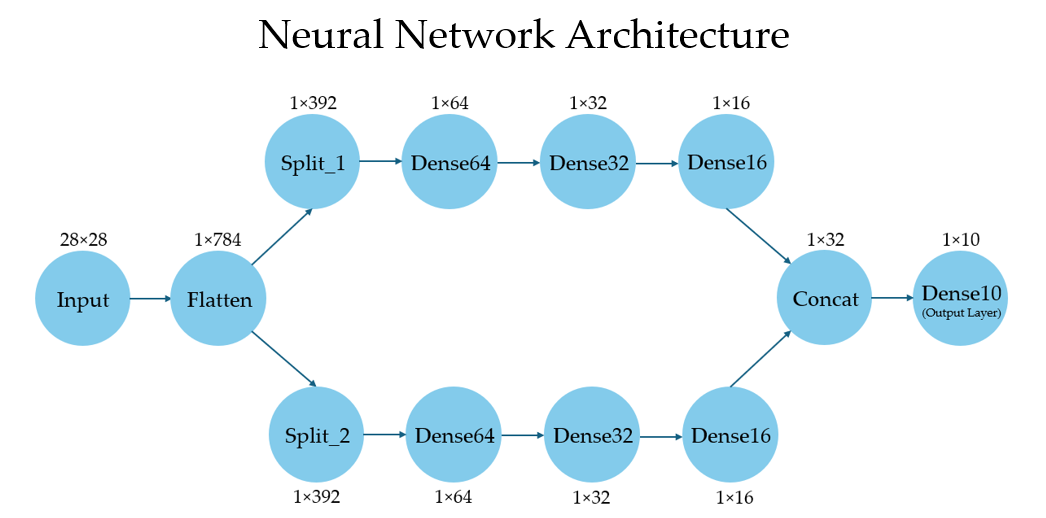

## 神經網路建立 (架構圖如上)

經過多次測試，我嘗試了不同層數的隱藏層組合，並分析其參數量與驗證準確率，測試結果: <br>
  - 兩層隱藏層: <br>
    - 64/32 (#Params=52,650): val_acc = 96.57%
  - 三層隱藏層: <br>
    - 16/16/16 (#Params=13,274): val_acc = 92.65%
    - 20/15/10 (#Params=16,285): val_acc = 93.61%
    - 25/20/15 (#Params=20,620): val_acc = 93.96%
    - 30/15/10 (#Params=24,285): val_acc = 95.33%
    - 30/20/15 (#Params=24,645): val_acc = 94.83%
    - 30/25/20 (#Params=25,055): val_acc = 95.45%
    - 32/16/10 (#Params=25.928): val_acc = 95.45%
    - 32/16/16 (#Params=26,090): val_acc = 95.59%
    - 32/32/16 (#Params=26,874): val_acc = 95.24%
  - 五層隱藏層: <br>
    - 32/32/32/16/16 (#Params=28,202): val_acc = 95.39%
    - 64/32/32/16/16 (#Params=54,346): val_acc = 96.53%
    - 64/64/32/32/16 (#Params=58,234): val_acc = 96.74%
    - 128/64/32/32/16 (#Params=112,570): val_acc = 97.13%

🔖 分析與觀察:

- 模型效能與總參數量的關係:

  測試結果顯示，**模型的表現與總參數量有密切關聯**，而**第一層的神經元數量**對總參數量影響最明顯

- 特徵萃取與參數量平衡:

  第一層神經元數量過少可能會導致特徵萃取不足，影響最終分類效果。因此，壓低參數量的同時，仍需確保第一層擁有足夠的神經元來學習關鍵特徵

🔖 創意解法:

- 為了兼顧**特徵萃取能力**與**降低參數量**，我想出了一種模型架構：

  - **將輸入向量拆分為兩部分**，分別進行特徵萃取與處理
  - **最後再合併特徵向量**，交由輸出層進行分類

- 這樣的設計讓**模型一次僅關注輸入圖像的一半**，但仍能萃取足夠的特徵，從而提升效能並控制參數量

- 設計架構測試結果:

 - 32/16/8 (#Params=26,650): val_acc = 96.60%
 - 32/16/16 (#Params=27,082): val_acc = 96.59%
 - 32/32 (#Params=27,914): val_acc = 96.38%

📌 **最終模型: 64/32/16 (#Params=55,850): val_acc = 97.49%**

- 此架構的網路效能可比純粹堆疊神經層的網路好上整整一倍

In [4]:
""" 建立神經網路 """
def build_branch(input_tensor, units_list):
  """ 建立子網路，根據指定的神經元數量進行堆疊 """
  x = input_tensor
  for units in units_list:
      x = Dense(units, activation='relu')(x)
  return x

def create_model():
  """ 建立雙分支神經網路 """
  # 1. 定義輸入層 (28x28圖像)
  input_layer = Input(shape=(28, 28))
  flatten_layer = Flatten()(input_layer)

  # 2. 切割輸入張量為兩部分
  top_branch = flatten_layer[:, :392]
  bot_branch = flatten_layer[:, 392:]

  # 3. 建立兩個子網路
  dense_1 = build_branch(top_branch, [64, 32, 16])
  dense_2 = build_branch(bot_branch, [64, 32, 16])

  # 4. 合併兩個子網路
  merged = Concatenate()([dense_1, dense_2])

  # 5. 輸出層
  output_layer = Dense(10, activation='softmax')(merged)

  # 6. 建立並回傳模型
  return Model(inputs=input_layer, outputs=output_layer)

## 模型建立與訓練流程:
1. 設定訓練模型: `model.compile()`<br>
  - `loss='categorical_crossentropy'`: 使用**類別交叉熵**作為損失函數，適用於多分類問題且標籤為 one-hot 編碼格式
  - `optimizer=Adam(learning_rate=0.001)`: 使用 Adam 優化器，設定初始學習率為 0.001，能自適應調整學習率，提高收斂速度
  - `metrics=['accuracy']`: 監測準確率（Accuracy），作為模型的評估指標
2. 檢視神經網路資訊: `model.summary()`
  - 顯示模型架構，包括層數、參數量、輸出形狀等資訊，確認模型結構是否正確
3. 設定 EarlyStopping 機制: `tf.keras.callbacks.EarlyStopping()`
  - `monitor = val_accuracy`: 指定監控指標
  - `patience = 10`: 如果監測指標連續10個epoch沒有更好，就停止訓練
  - `mode = 'max'`: val_accuracy 越大越好
  - `restore_best_weights = True`: 確保模型停止後回復到最佳的狀態，而非最後一次訓練的模型參數
4. 模型訓練: `model.fit()`
  - 本訓練將資料集中的10000筆測試資料作為模型的驗證資料
  - 將Batchsize設定為32，最多訓練50個Epoch，並加入EarlyStopping機制

In [5]:
""" 設定訓練模型 """
model = create_model()
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

""" 檢視神經網路資訊 """
model.summary()

""" EarlyStopping 機制設定 """
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, mode='max', restore_best_weights=True)

""" 模型訓練與測試 """
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=32, epochs=50, callbacks=[early_stopping])

# Print specific metrics
print("Final Training Loss:", history.history['loss'][-11])
print("Final Validation Loss:", history.history['val_loss'][-11])
print("Final Training Accuracy:", history.history['accuracy'][-11])
print("Final Validation Accuracy:", history.history['val_accuracy'][-11])

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 28, 28)         │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 784)            │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item (GetItem)        │ (None, 392)            │              0 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_1 (GetItem)      │ (None, 392)            │              0 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 64)             │         25,152 │ get_item[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 64)             │         25,152 │ get_item_1[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 32)             │          2,080 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 32)             │          2,080 │ dense_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 16)             │            528 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 16)             │            528 │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 32)             │              0 │ dense_2[0][0],         │
│                           │                        │                │ dense_5[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 10)             │            330 │ concatenate[0][0]      │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 55,850 (218.16 KB)

 Trainable params: 55,850 (218.16 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - accuracy: 0.6901 - loss: 6.0390 - val_accuracy: 0.8942 - val_loss: 0.4134
Epoch 2/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9054 - loss: 0.3591 - val_accuracy: 0.9309 - val_loss: 0.2454
Epoch 3/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9344 - loss: 0.2301 - val_accuracy: 0.9465 - val_loss: 0.1842
Epoch 4/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9528 - loss: 0.1614 - val_accuracy: 0.9439 - val_loss: 0.2021
Epoch 5/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9627 - loss: 0.1268 - val_accuracy: 0.9578 - val_loss: 0.1511
Epoch 6/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9689 - loss: 0.1092 - val_accuracy: 0.9664 - val_loss: 0.1133
Epoch 7/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9700 - loss: 0.0975 - val_accuracy: 0.9628 - val_loss: 0.1352
Epoch 8/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9743 - loss: 0.08

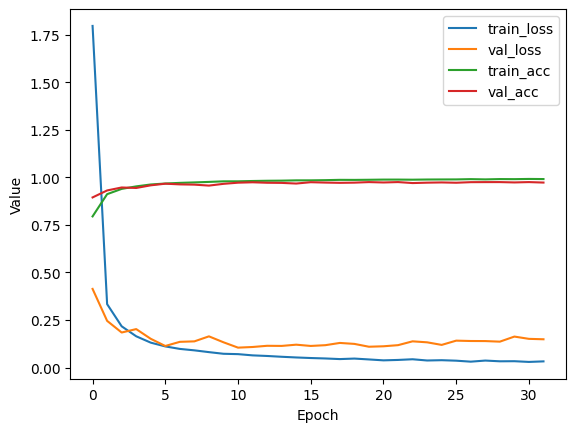

In [6]:
""" 訓練過程數據圖 """
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  plt.plot(hist['epoch'], hist['loss'], label='train_loss')
  plt.plot(hist['epoch'], hist['val_loss'], label='val_loss')
  plt.plot(hist['epoch'], hist['accuracy'], label='train_acc')
  plt.plot(hist['epoch'], hist['val_accuracy'], label='val_acc')
  plt.xlabel('Epoch')
  plt.ylabel('Value')
  plt.legend()

plot_history(history)

In [7]:
def resize_image(inp):
  """ 將輸入圖像轉換為 MNIST 兼容的 28x28 灰階圖 """
  image = np.array(inp["layers"][0], dtype=np.uint8)
  image_pil = Image.fromarray(image) # 轉 PIL 處理比較方便

  # 若為 RGBA，轉換為 RGB 並設置白色背景
  if image_pil.mode == "RGBA":
    background = Image.new("RGB", image_pil.size, (255, 255, 255))
    background.paste(image_pil, mask=image_pil.getchannel("A"))
    image_pil = background

  # 轉換為灰階並縮放
  image_gray = image_pil.convert("L").resize((28, 28), resample=Image.LANCZOS)

  # 轉換為 numpy 格式，並反轉顏色配合 MNIST 資料集
  img_array = 255 - np.array(image_gray, dtype=np.uint8)
  return np.expand_dims(img_array, axis=0)

In [8]:
def recognize_digit(inp):
  """ 對手繪數字進行預測 """
  img_array = resize_image(inp)
  prediction = model.predict(img_array).flatten()
  labels = list('0123456789')
  return dict(zip(labels, prediction)) # 轉換為字典輸出

In [9]:
""" 設定 Gradio Digit Classifier """
iface = gr.Interface(
    fn=recognize_digit,
    inputs=gr.Sketchpad(),
    outputs=gr.Label(num_top_classes=3),
    title="Digit Classifier")

iface.launch(share=True, debug=True) # 執行 Gradio Digit Classifier

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://fbbd303547c2059fd9.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://fbbd303547c2059fd9.gradio.live
